In [1]:
import torch
import torch.nn as nn

import numpy as np
import random
from model import QNetwork, get_network_input
from Game import GameEnvironment
from collections import deque
from replay_buffer import ReplayMemory
import time

model = QNetwork(input_dim=10, hidden_dim=20, output_dim=5)
epsilon = 0.1
gridsize = 15 
GAMMA = 0.99

board = GameEnvironment(gridsize, nothing=0, dead=-1, apple=1)
memory = ReplayMemory(1000)  
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)


In [2]:
def run_episode(num_games):
    run = True
    move=0
    games_played = 0
    total_reward = 0    
    episode_games = 0
    len_array = []
    
    while run:
        state = get_network_input(board.snake, board.apple)
        action_0 = model(state_0)
        rand = np.random.uniform(0,1)
        if rand > epsilon:
            action = torch.argmax(action_0)
        else:
            action = np.random.randint(0,5)

        ## update_boardstate the same snake till    
        reward, done, len_of_snake = board.update_boardstate(action)
        next_state = get_network_input(board.snake, board.apple)
        
        memory.push(state, action, reward, next_state, done)
        
        total_reward += reward
        
        episode_games += 1
        
        if board.game_over == True:
            games_played += 1
            len_array.append(len_of_snake)
            board.resetgame()
            
            if num_games == games_played:
                run = False
                
    avg_len_of_snake = np.mean(len_array)
    max_len_of_snake = np.max(len_array)
    return total_reward, avg_len_of_snake, max_len_of_snake

In [3]:
MSE = nn.MSELoss()
def learn(num_updates, batch_size):
    
    total_loss = 0
    
    for i in range(num_updates):

        optimizer.zero_grad()
        sample = memory.sample(batch_size)
            
        states, actions, rewards, next_states, dones = sample
        states = torch.cat([x.unsqueeze(0) for x in states], dim=0) 
        actions = torch.LongTensor(actions) 
        rewards = torch.FloatTensor(rewards) 
        next_states = torch.cat([x.unsqueeze(0) for x in next_states]) 
        dones = torch.FloatTensor(dones) 
        
        q_local = model.forward(states)
        next_q_value = model.forward(next_states)

        Q_expected  = q_local.gather(1, actions.unsqueeze(0).transpose(0,1)).transpose(0,1).squeeze(0)  
        
        Q_targets_next  = torch.max(next_q_value, 1)[0]*(torch.ones(dones.size()) - dones)
        
        Q_targets  = rewards + GAMMA * Q_targets_next 
        
        loss = MSE(Q_expected, Q_targets)
        
        total_loss += loss
        loss.backward()
        optimizer.step()
        
    return total_loss

In [4]:
num_episodes = 50000 
num_updates = 500 
print_every = 10
games_in_episode = 30
batch_size = 20


def train():
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    
    
    avg_len_array = []
    avg_max_len_array = []
    
    time_start = time.time()
    
    
    for i_episode in range(num_episodes+1):
        
        ## print('i_episode: ', i_episode)
        
        score, avg_len, max_len = run_episode(games_in_episode)
        
        scores_deque.append(score)
        scores_array.append(score)
        avg_len_array.append(avg_len)
        avg_max_len_array.append(max_len)
        
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        total_loss = learn(num_updates, batch_size)
        
        dt = (int)(time.time() - time_start)
        
        if i_episode % print_every == 0 and i_episode > 0:
            print('Ep.: {:6}, Loss: {:.3f}, Avg.Score: {:.2f}, Avg.LenOfSnake: {:.2f}, Max.LenOfSnake:  {:.2f} Time: {:02}:{:02}:{:02} '.\
                  format(i_episode, total_loss, score, avg_len, max_len, dt//3600, dt%3600//60, dt%60))
            
        memory.truncate()
        
        if i_episode % 250 == 0 and i_episode > 0:   
            torch.save(model.state_dict(), './dir_chk_len/Snake_{}'.format(i_episode))
            
    return scores_array, avg_scores_array, avg_len_array, avg_max_len_array    

scores, avg_scores, avg_len_of_snake, max_len_of_snake = train()

Ep.:     10, Loss: 2.630, Avg.Score: -26.00, Avg.LenOfSnake: 5.13, Max.LenOfSnake:  6.00 Time: 00:00:17 
Ep.:     20, Loss: 3.440, Avg.Score: -27.00, Avg.LenOfSnake: 5.10, Max.LenOfSnake:  6.00 Time: 00:00:36 
Ep.:     30, Loss: 2.275, Avg.Score: -22.00, Avg.LenOfSnake: 5.27, Max.LenOfSnake:  8.00 Time: 00:00:54 
Ep.:     40, Loss: 2.357, Avg.Score: -29.00, Avg.LenOfSnake: 5.03, Max.LenOfSnake:  6.00 Time: 00:01:12 
Ep.:     50, Loss: 3.202, Avg.Score: -27.00, Avg.LenOfSnake: 5.10, Max.LenOfSnake:  6.00 Time: 00:01:31 
Ep.:     60, Loss: 5.572, Avg.Score: -18.00, Avg.LenOfSnake: 5.40, Max.LenOfSnake:  7.00 Time: 00:01:46 
Ep.:     70, Loss: 6.686, Avg.Score: -14.00, Avg.LenOfSnake: 5.53, Max.LenOfSnake:  8.00 Time: 00:02:05 
Ep.:     80, Loss: 9.235, Avg.Score: 4.00, Avg.LenOfSnake: 6.13, Max.LenOfSnake:  10.00 Time: 00:02:22 
Ep.:     90, Loss: 6.334, Avg.Score: -16.00, Avg.LenOfSnake: 5.47, Max.LenOfSnake:  7.00 Time: 00:02:37 
Ep.:    100, Loss: 6.445, Avg.Score: -20.00, Avg.LenOfSn

Ep.:   1550, Loss: 10.406, Avg.Score: 99.00, Avg.LenOfSnake: 9.30, Max.LenOfSnake:  21.00 Time: 00:50:33 
Ep.:   1560, Loss: 11.272, Avg.Score: 128.00, Avg.LenOfSnake: 10.27, Max.LenOfSnake:  22.00 Time: 00:50:55 
Ep.:   1570, Loss: 11.489, Avg.Score: 112.00, Avg.LenOfSnake: 9.73, Max.LenOfSnake:  20.00 Time: 00:51:16 
Ep.:   1580, Loss: 11.398, Avg.Score: 103.00, Avg.LenOfSnake: 9.43, Max.LenOfSnake:  18.00 Time: 00:51:37 
Ep.:   1590, Loss: 9.850, Avg.Score: 85.00, Avg.LenOfSnake: 8.83, Max.LenOfSnake:  14.00 Time: 00:51:59 
Ep.:   1600, Loss: 11.613, Avg.Score: 100.00, Avg.LenOfSnake: 9.33, Max.LenOfSnake:  23.00 Time: 00:52:20 
Ep.:   1610, Loss: 9.314, Avg.Score: 97.00, Avg.LenOfSnake: 9.23, Max.LenOfSnake:  20.00 Time: 00:52:41 
Ep.:   1620, Loss: 9.793, Avg.Score: 67.00, Avg.LenOfSnake: 8.23, Max.LenOfSnake:  13.00 Time: 00:53:02 
Ep.:   1630, Loss: 12.120, Avg.Score: 98.00, Avg.LenOfSnake: 9.27, Max.LenOfSnake:  20.00 Time: 00:53:22 
Ep.:   1640, Loss: 9.671, Avg.Score: 53.00, 

Ep.:   3090, Loss: 10.258, Avg.Score: 113.00, Avg.LenOfSnake: 9.77, Max.LenOfSnake:  18.00 Time: 02:02:48 
Ep.:   3100, Loss: 10.280, Avg.Score: 126.00, Avg.LenOfSnake: 10.20, Max.LenOfSnake:  21.00 Time: 02:03:38 
Ep.:   3110, Loss: 9.745, Avg.Score: 126.00, Avg.LenOfSnake: 10.20, Max.LenOfSnake:  29.00 Time: 02:05:55 
Ep.:   3120, Loss: 10.074, Avg.Score: 91.00, Avg.LenOfSnake: 9.03, Max.LenOfSnake:  17.00 Time: 02:06:24 
Ep.:   3130, Loss: 9.532, Avg.Score: 136.00, Avg.LenOfSnake: 10.53, Max.LenOfSnake:  18.00 Time: 02:06:47 
Ep.:   3140, Loss: 11.750, Avg.Score: 103.00, Avg.LenOfSnake: 9.43, Max.LenOfSnake:  22.00 Time: 02:07:23 
Ep.:   3150, Loss: 11.062, Avg.Score: 94.00, Avg.LenOfSnake: 9.13, Max.LenOfSnake:  17.00 Time: 02:08:01 
Ep.:   3160, Loss: 9.136, Avg.Score: 119.00, Avg.LenOfSnake: 9.97, Max.LenOfSnake:  20.00 Time: 02:09:02 
Ep.:   3170, Loss: 9.690, Avg.Score: 113.00, Avg.LenOfSnake: 9.77, Max.LenOfSnake:  19.00 Time: 02:09:44 
Ep.:   3180, Loss: 11.633, Avg.Score: 11

Ep.:   4620, Loss: 9.990, Avg.Score: 75.00, Avg.LenOfSnake: 8.50, Max.LenOfSnake:  14.00 Time: 03:46:24 
Ep.:   4630, Loss: 11.313, Avg.Score: 115.00, Avg.LenOfSnake: 9.83, Max.LenOfSnake:  22.00 Time: 03:47:03 
Ep.:   4640, Loss: 9.812, Avg.Score: 45.00, Avg.LenOfSnake: 7.50, Max.LenOfSnake:  12.00 Time: 03:47:43 
Ep.:   4650, Loss: 9.467, Avg.Score: 78.00, Avg.LenOfSnake: 8.60, Max.LenOfSnake:  16.00 Time: 03:48:21 
Ep.:   4660, Loss: 10.181, Avg.Score: 181.00, Avg.LenOfSnake: 12.03, Max.LenOfSnake:  23.00 Time: 03:49:03 
Ep.:   4670, Loss: 9.972, Avg.Score: 95.00, Avg.LenOfSnake: 9.17, Max.LenOfSnake:  21.00 Time: 03:49:46 
Ep.:   4680, Loss: 9.987, Avg.Score: 104.00, Avg.LenOfSnake: 9.47, Max.LenOfSnake:  21.00 Time: 03:50:25 
Ep.:   4690, Loss: 10.773, Avg.Score: 133.00, Avg.LenOfSnake: 10.43, Max.LenOfSnake:  26.00 Time: 03:51:03 
Ep.:   4700, Loss: 11.394, Avg.Score: 95.00, Avg.LenOfSnake: 9.17, Max.LenOfSnake:  17.00 Time: 03:51:43 
Ep.:   4710, Loss: 11.028, Avg.Score: 107.00,

Ep.:   6140, Loss: 11.901, Avg.Score: 148.00, Avg.LenOfSnake: 10.93, Max.LenOfSnake:  24.00 Time: 05:03:15 
Ep.:   6150, Loss: 10.547, Avg.Score: 128.00, Avg.LenOfSnake: 10.27, Max.LenOfSnake:  18.00 Time: 05:03:39 
Ep.:   6160, Loss: 10.763, Avg.Score: 104.00, Avg.LenOfSnake: 9.47, Max.LenOfSnake:  16.00 Time: 05:04:06 
Ep.:   6170, Loss: 9.719, Avg.Score: 114.00, Avg.LenOfSnake: 9.80, Max.LenOfSnake:  27.00 Time: 05:04:32 
Ep.:   6180, Loss: 10.618, Avg.Score: 103.00, Avg.LenOfSnake: 9.43, Max.LenOfSnake:  20.00 Time: 05:05:08 
Ep.:   6190, Loss: 11.126, Avg.Score: 106.00, Avg.LenOfSnake: 9.53, Max.LenOfSnake:  20.00 Time: 05:05:36 
Ep.:   6200, Loss: 10.347, Avg.Score: 82.00, Avg.LenOfSnake: 8.73, Max.LenOfSnake:  14.00 Time: 05:06:01 
Ep.:   6210, Loss: 9.953, Avg.Score: 75.00, Avg.LenOfSnake: 8.50, Max.LenOfSnake:  14.00 Time: 05:06:21 
Ep.:   6220, Loss: 11.121, Avg.Score: 93.00, Avg.LenOfSnake: 9.10, Max.LenOfSnake:  21.00 Time: 05:06:42 
Ep.:   6230, Loss: 11.203, Avg.Score: 11

Ep.:   7660, Loss: 9.562, Avg.Score: 118.00, Avg.LenOfSnake: 9.93, Max.LenOfSnake:  19.00 Time: 06:02:42 
Ep.:   7670, Loss: 10.844, Avg.Score: 139.00, Avg.LenOfSnake: 10.63, Max.LenOfSnake:  22.00 Time: 06:03:05 
Ep.:   7680, Loss: 10.727, Avg.Score: 127.00, Avg.LenOfSnake: 10.23, Max.LenOfSnake:  18.00 Time: 06:03:34 
Ep.:   7690, Loss: 9.818, Avg.Score: 111.00, Avg.LenOfSnake: 9.70, Max.LenOfSnake:  22.00 Time: 06:04:18 
Ep.:   7700, Loss: 8.604, Avg.Score: 130.00, Avg.LenOfSnake: 10.33, Max.LenOfSnake:  21.00 Time: 06:05:01 
Ep.:   7710, Loss: 9.848, Avg.Score: 103.00, Avg.LenOfSnake: 9.43, Max.LenOfSnake:  21.00 Time: 06:05:27 
Ep.:   7720, Loss: 10.011, Avg.Score: 124.00, Avg.LenOfSnake: 10.13, Max.LenOfSnake:  18.00 Time: 06:05:54 
Ep.:   7730, Loss: 9.189, Avg.Score: 111.00, Avg.LenOfSnake: 9.70, Max.LenOfSnake:  19.00 Time: 06:06:20 
Ep.:   7740, Loss: 8.870, Avg.Score: 156.00, Avg.LenOfSnake: 11.20, Max.LenOfSnake:  17.00 Time: 06:06:45 
Ep.:   7750, Loss: 10.316, Avg.Score: 

Ep.:   9180, Loss: 9.996, Avg.Score: 169.00, Avg.LenOfSnake: 11.63, Max.LenOfSnake:  24.00 Time: 07:37:16 
Ep.:   9190, Loss: 9.628, Avg.Score: 121.00, Avg.LenOfSnake: 10.03, Max.LenOfSnake:  22.00 Time: 07:37:57 
Ep.:   9200, Loss: 11.575, Avg.Score: 83.00, Avg.LenOfSnake: 8.77, Max.LenOfSnake:  17.00 Time: 07:38:36 
Ep.:   9210, Loss: 10.624, Avg.Score: 102.00, Avg.LenOfSnake: 9.40, Max.LenOfSnake:  17.00 Time: 07:39:18 
Ep.:   9220, Loss: 9.916, Avg.Score: 88.00, Avg.LenOfSnake: 8.93, Max.LenOfSnake:  15.00 Time: 07:40:03 
Ep.:   9230, Loss: 10.451, Avg.Score: 100.00, Avg.LenOfSnake: 9.33, Max.LenOfSnake:  18.00 Time: 07:40:41 
Ep.:   9240, Loss: 10.679, Avg.Score: 135.00, Avg.LenOfSnake: 10.50, Max.LenOfSnake:  24.00 Time: 07:41:06 
Ep.:   9250, Loss: 8.962, Avg.Score: 150.00, Avg.LenOfSnake: 11.00, Max.LenOfSnake:  19.00 Time: 07:41:37 
Ep.:   9260, Loss: 9.575, Avg.Score: 158.00, Avg.LenOfSnake: 11.27, Max.LenOfSnake:  24.00 Time: 07:42:07 
Ep.:   9270, Loss: 10.947, Avg.Score: 1

Ep.:  10700, Loss: 10.942, Avg.Score: 125.00, Avg.LenOfSnake: 10.17, Max.LenOfSnake:  22.00 Time: 08:37:50 
Ep.:  10710, Loss: 9.725, Avg.Score: 158.00, Avg.LenOfSnake: 11.27, Max.LenOfSnake:  22.00 Time: 08:38:16 
Ep.:  10720, Loss: 9.381, Avg.Score: 124.00, Avg.LenOfSnake: 10.13, Max.LenOfSnake:  20.00 Time: 08:38:40 
Ep.:  10730, Loss: 10.504, Avg.Score: 89.00, Avg.LenOfSnake: 8.97, Max.LenOfSnake:  18.00 Time: 08:39:02 
Ep.:  10740, Loss: 10.335, Avg.Score: 113.00, Avg.LenOfSnake: 9.77, Max.LenOfSnake:  21.00 Time: 08:39:23 
Ep.:  10750, Loss: 9.833, Avg.Score: 102.00, Avg.LenOfSnake: 9.40, Max.LenOfSnake:  18.00 Time: 08:39:46 
Ep.:  10760, Loss: 10.649, Avg.Score: 105.00, Avg.LenOfSnake: 9.50, Max.LenOfSnake:  22.00 Time: 08:40:09 
Ep.:  10770, Loss: 10.147, Avg.Score: 164.00, Avg.LenOfSnake: 11.47, Max.LenOfSnake:  27.00 Time: 08:40:34 
Ep.:  10780, Loss: 10.267, Avg.Score: 148.00, Avg.LenOfSnake: 10.93, Max.LenOfSnake:  21.00 Time: 08:40:56 
Ep.:  10790, Loss: 10.870, Avg.Score

Ep.:  12220, Loss: 9.437, Avg.Score: 92.00, Avg.LenOfSnake: 9.07, Max.LenOfSnake:  16.00 Time: 09:35:53 
Ep.:  12230, Loss: 10.674, Avg.Score: 125.00, Avg.LenOfSnake: 10.17, Max.LenOfSnake:  23.00 Time: 09:36:16 
Ep.:  12240, Loss: 9.329, Avg.Score: 143.00, Avg.LenOfSnake: 10.77, Max.LenOfSnake:  24.00 Time: 09:36:40 
Ep.:  12250, Loss: 9.502, Avg.Score: 98.00, Avg.LenOfSnake: 9.27, Max.LenOfSnake:  18.00 Time: 09:37:06 
Ep.:  12260, Loss: 11.894, Avg.Score: 108.00, Avg.LenOfSnake: 9.60, Max.LenOfSnake:  23.00 Time: 09:37:53 
Ep.:  12270, Loss: 10.675, Avg.Score: 139.00, Avg.LenOfSnake: 10.63, Max.LenOfSnake:  19.00 Time: 09:38:19 
Ep.:  12280, Loss: 10.463, Avg.Score: 129.00, Avg.LenOfSnake: 10.30, Max.LenOfSnake:  19.00 Time: 09:38:50 
Ep.:  12290, Loss: 8.807, Avg.Score: 142.00, Avg.LenOfSnake: 10.73, Max.LenOfSnake:  21.00 Time: 09:39:15 
Ep.:  12300, Loss: 10.373, Avg.Score: 89.00, Avg.LenOfSnake: 8.97, Max.LenOfSnake:  17.00 Time: 09:39:37 
Ep.:  12310, Loss: 9.721, Avg.Score: 12

Ep.:  13740, Loss: 9.166, Avg.Score: 116.00, Avg.LenOfSnake: 9.87, Max.LenOfSnake:  19.00 Time: 10:38:22 
Ep.:  13750, Loss: 10.512, Avg.Score: 195.00, Avg.LenOfSnake: 12.50, Max.LenOfSnake:  30.00 Time: 10:38:48 
Ep.:  13760, Loss: 10.009, Avg.Score: 117.00, Avg.LenOfSnake: 9.90, Max.LenOfSnake:  17.00 Time: 10:39:14 
Ep.:  13770, Loss: 9.696, Avg.Score: 143.00, Avg.LenOfSnake: 10.77, Max.LenOfSnake:  23.00 Time: 10:39:39 
Ep.:  13780, Loss: 9.811, Avg.Score: 143.00, Avg.LenOfSnake: 10.77, Max.LenOfSnake:  20.00 Time: 10:40:02 
Ep.:  13790, Loss: 9.293, Avg.Score: 100.00, Avg.LenOfSnake: 9.33, Max.LenOfSnake:  19.00 Time: 10:40:24 
Ep.:  13800, Loss: 10.035, Avg.Score: 188.00, Avg.LenOfSnake: 12.27, Max.LenOfSnake:  27.00 Time: 10:40:46 
Ep.:  13810, Loss: 10.734, Avg.Score: 141.00, Avg.LenOfSnake: 10.70, Max.LenOfSnake:  20.00 Time: 10:41:11 
Ep.:  13820, Loss: 9.752, Avg.Score: 151.00, Avg.LenOfSnake: 11.03, Max.LenOfSnake:  25.00 Time: 10:41:35 
Ep.:  13830, Loss: 9.547, Avg.Score:

Ep.:  15260, Loss: 8.916, Avg.Score: 207.00, Avg.LenOfSnake: 12.90, Max.LenOfSnake:  25.00 Time: 11:45:33 
Ep.:  15270, Loss: 9.546, Avg.Score: 149.00, Avg.LenOfSnake: 10.97, Max.LenOfSnake:  20.00 Time: 11:46:01 
Ep.:  15280, Loss: 9.109, Avg.Score: 185.00, Avg.LenOfSnake: 12.17, Max.LenOfSnake:  25.00 Time: 11:46:30 
Ep.:  15290, Loss: 10.001, Avg.Score: 219.00, Avg.LenOfSnake: 13.30, Max.LenOfSnake:  19.00 Time: 11:46:59 
Ep.:  15300, Loss: 9.269, Avg.Score: 157.00, Avg.LenOfSnake: 11.23, Max.LenOfSnake:  26.00 Time: 11:47:25 
Ep.:  15310, Loss: 9.949, Avg.Score: 220.00, Avg.LenOfSnake: 13.33, Max.LenOfSnake:  24.00 Time: 11:47:53 
Ep.:  15320, Loss: 8.954, Avg.Score: 208.00, Avg.LenOfSnake: 12.93, Max.LenOfSnake:  26.00 Time: 11:48:19 
Ep.:  15330, Loss: 9.283, Avg.Score: 229.00, Avg.LenOfSnake: 13.63, Max.LenOfSnake:  29.00 Time: 11:48:47 
Ep.:  15340, Loss: 8.917, Avg.Score: 175.00, Avg.LenOfSnake: 11.83, Max.LenOfSnake:  23.00 Time: 11:49:15 
Ep.:  15350, Loss: 8.571, Avg.Score:

Ep.:  16780, Loss: 9.697, Avg.Score: 221.00, Avg.LenOfSnake: 13.37, Max.LenOfSnake:  27.00 Time: 13:00:04 
Ep.:  16790, Loss: 8.833, Avg.Score: 202.00, Avg.LenOfSnake: 12.73, Max.LenOfSnake:  26.00 Time: 13:00:32 
Ep.:  16800, Loss: 8.859, Avg.Score: 175.00, Avg.LenOfSnake: 11.83, Max.LenOfSnake:  30.00 Time: 13:00:57 
Ep.:  16810, Loss: 8.243, Avg.Score: 157.00, Avg.LenOfSnake: 11.23, Max.LenOfSnake:  22.00 Time: 13:01:26 
Ep.:  16820, Loss: 10.733, Avg.Score: 240.00, Avg.LenOfSnake: 14.00, Max.LenOfSnake:  26.00 Time: 13:01:55 
Ep.:  16830, Loss: 9.247, Avg.Score: 186.00, Avg.LenOfSnake: 12.20, Max.LenOfSnake:  26.00 Time: 13:02:26 
Ep.:  16840, Loss: 10.074, Avg.Score: 191.00, Avg.LenOfSnake: 12.37, Max.LenOfSnake:  20.00 Time: 13:02:56 
Ep.:  16850, Loss: 7.880, Avg.Score: 156.00, Avg.LenOfSnake: 11.20, Max.LenOfSnake:  19.00 Time: 13:03:24 
Ep.:  16860, Loss: 10.045, Avg.Score: 264.00, Avg.LenOfSnake: 14.80, Max.LenOfSnake:  30.00 Time: 13:03:53 
Ep.:  16870, Loss: 9.885, Avg.Scor

Ep.:  18300, Loss: 10.287, Avg.Score: 238.00, Avg.LenOfSnake: 13.93, Max.LenOfSnake:  25.00 Time: 14:16:57 
Ep.:  18310, Loss: 8.158, Avg.Score: 196.00, Avg.LenOfSnake: 12.53, Max.LenOfSnake:  25.00 Time: 14:17:30 
Ep.:  18320, Loss: 9.229, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  28.00 Time: 14:18:01 
Ep.:  18330, Loss: 9.892, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  34.00 Time: 14:18:31 
Ep.:  18340, Loss: 8.992, Avg.Score: 161.00, Avg.LenOfSnake: 11.37, Max.LenOfSnake:  29.00 Time: 14:19:01 
Ep.:  18350, Loss: 9.281, Avg.Score: 246.00, Avg.LenOfSnake: 14.20, Max.LenOfSnake:  27.00 Time: 14:19:34 
Ep.:  18360, Loss: 8.621, Avg.Score: 276.00, Avg.LenOfSnake: 15.20, Max.LenOfSnake:  32.00 Time: 14:20:06 
Ep.:  18370, Loss: 8.757, Avg.Score: 240.00, Avg.LenOfSnake: 14.00, Max.LenOfSnake:  25.00 Time: 14:20:39 
Ep.:  18380, Loss: 10.159, Avg.Score: 193.00, Avg.LenOfSnake: 12.43, Max.LenOfSnake:  31.00 Time: 14:21:08 
Ep.:  18390, Loss: 9.338, Avg.Score

Ep.:  19820, Loss: 9.131, Avg.Score: 214.00, Avg.LenOfSnake: 13.13, Max.LenOfSnake:  26.00 Time: 15:33:36 
Ep.:  19830, Loss: 8.858, Avg.Score: 252.00, Avg.LenOfSnake: 14.40, Max.LenOfSnake:  24.00 Time: 15:34:05 
Ep.:  19840, Loss: 10.507, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  25.00 Time: 15:34:36 
Ep.:  19850, Loss: 9.993, Avg.Score: 218.00, Avg.LenOfSnake: 13.27, Max.LenOfSnake:  29.00 Time: 15:35:07 
Ep.:  19860, Loss: 9.940, Avg.Score: 233.00, Avg.LenOfSnake: 13.77, Max.LenOfSnake:  31.00 Time: 15:35:38 
Ep.:  19870, Loss: 10.210, Avg.Score: 276.00, Avg.LenOfSnake: 15.20, Max.LenOfSnake:  29.00 Time: 15:36:10 
Ep.:  19880, Loss: 8.385, Avg.Score: 201.00, Avg.LenOfSnake: 12.70, Max.LenOfSnake:  21.00 Time: 15:36:41 
Ep.:  19890, Loss: 10.150, Avg.Score: 207.00, Avg.LenOfSnake: 12.90, Max.LenOfSnake:  21.00 Time: 15:37:13 
Ep.:  19900, Loss: 8.768, Avg.Score: 203.00, Avg.LenOfSnake: 12.77, Max.LenOfSnake:  30.00 Time: 15:37:45 
Ep.:  19910, Loss: 9.926, Avg.Scor

Ep.:  21340, Loss: 9.277, Avg.Score: 275.00, Avg.LenOfSnake: 15.17, Max.LenOfSnake:  31.00 Time: 16:52:22 
Ep.:  21350, Loss: 9.585, Avg.Score: 212.00, Avg.LenOfSnake: 13.07, Max.LenOfSnake:  23.00 Time: 16:52:56 
Ep.:  21360, Loss: 9.204, Avg.Score: 238.00, Avg.LenOfSnake: 13.93, Max.LenOfSnake:  27.00 Time: 16:53:26 
Ep.:  21370, Loss: 9.770, Avg.Score: 224.00, Avg.LenOfSnake: 13.47, Max.LenOfSnake:  24.00 Time: 16:53:58 
Ep.:  21380, Loss: 8.882, Avg.Score: 268.00, Avg.LenOfSnake: 14.93, Max.LenOfSnake:  28.00 Time: 16:54:29 
Ep.:  21390, Loss: 8.091, Avg.Score: 236.00, Avg.LenOfSnake: 13.87, Max.LenOfSnake:  31.00 Time: 16:55:02 
Ep.:  21400, Loss: 9.302, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  24.00 Time: 16:55:34 
Ep.:  21410, Loss: 8.690, Avg.Score: 159.00, Avg.LenOfSnake: 11.30, Max.LenOfSnake:  23.00 Time: 16:56:09 
Ep.:  21420, Loss: 8.128, Avg.Score: 229.00, Avg.LenOfSnake: 13.63, Max.LenOfSnake:  28.00 Time: 16:56:40 
Ep.:  21430, Loss: 9.769, Avg.Score: 

Ep.:  22860, Loss: 10.485, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  27.00 Time: 18:12:28 
Ep.:  22870, Loss: 8.238, Avg.Score: 181.00, Avg.LenOfSnake: 12.03, Max.LenOfSnake:  23.00 Time: 18:12:58 
Ep.:  22880, Loss: 10.184, Avg.Score: 263.00, Avg.LenOfSnake: 14.77, Max.LenOfSnake:  29.00 Time: 18:13:31 
Ep.:  22890, Loss: 7.976, Avg.Score: 227.00, Avg.LenOfSnake: 13.57, Max.LenOfSnake:  28.00 Time: 18:14:02 
Ep.:  22900, Loss: 8.199, Avg.Score: 274.00, Avg.LenOfSnake: 15.13, Max.LenOfSnake:  25.00 Time: 18:14:34 
Ep.:  22910, Loss: 8.936, Avg.Score: 242.00, Avg.LenOfSnake: 14.07, Max.LenOfSnake:  28.00 Time: 18:15:05 
Ep.:  22920, Loss: 10.005, Avg.Score: 262.00, Avg.LenOfSnake: 14.73, Max.LenOfSnake:  27.00 Time: 18:15:41 
Ep.:  22930, Loss: 9.057, Avg.Score: 225.00, Avg.LenOfSnake: 13.50, Max.LenOfSnake:  27.00 Time: 18:16:12 
Ep.:  22940, Loss: 10.515, Avg.Score: 251.00, Avg.LenOfSnake: 14.37, Max.LenOfSnake:  28.00 Time: 18:16:42 
Ep.:  22950, Loss: 9.556, Avg.Sco

Ep.:  24380, Loss: 7.373, Avg.Score: 150.00, Avg.LenOfSnake: 11.00, Max.LenOfSnake:  21.00 Time: 19:34:10 
Ep.:  24390, Loss: 8.780, Avg.Score: 214.00, Avg.LenOfSnake: 13.13, Max.LenOfSnake:  27.00 Time: 19:34:42 
Ep.:  24400, Loss: 8.838, Avg.Score: 164.00, Avg.LenOfSnake: 11.47, Max.LenOfSnake:  20.00 Time: 19:35:14 
Ep.:  24410, Loss: 8.076, Avg.Score: 259.00, Avg.LenOfSnake: 14.63, Max.LenOfSnake:  28.00 Time: 19:35:47 
Ep.:  24420, Loss: 8.243, Avg.Score: 238.00, Avg.LenOfSnake: 13.93, Max.LenOfSnake:  24.00 Time: 19:36:19 
Ep.:  24430, Loss: 9.592, Avg.Score: 278.00, Avg.LenOfSnake: 15.27, Max.LenOfSnake:  24.00 Time: 19:36:52 
Ep.:  24440, Loss: 9.049, Avg.Score: 263.00, Avg.LenOfSnake: 14.77, Max.LenOfSnake:  23.00 Time: 19:37:24 
Ep.:  24450, Loss: 9.384, Avg.Score: 202.00, Avg.LenOfSnake: 12.73, Max.LenOfSnake:  23.00 Time: 19:37:53 
Ep.:  24460, Loss: 9.429, Avg.Score: 221.00, Avg.LenOfSnake: 13.37, Max.LenOfSnake:  24.00 Time: 19:38:25 
Ep.:  24470, Loss: 9.257, Avg.Score: 

Ep.:  25900, Loss: 9.166, Avg.Score: 288.00, Avg.LenOfSnake: 15.60, Max.LenOfSnake:  32.00 Time: 20:57:04 
Ep.:  25910, Loss: 9.344, Avg.Score: 223.00, Avg.LenOfSnake: 13.43, Max.LenOfSnake:  31.00 Time: 20:57:37 
Ep.:  25920, Loss: 9.257, Avg.Score: 234.00, Avg.LenOfSnake: 13.80, Max.LenOfSnake:  26.00 Time: 20:58:09 
Ep.:  25930, Loss: 8.312, Avg.Score: 280.00, Avg.LenOfSnake: 15.33, Max.LenOfSnake:  34.00 Time: 20:58:41 
Ep.:  25940, Loss: 9.106, Avg.Score: 214.00, Avg.LenOfSnake: 13.13, Max.LenOfSnake:  31.00 Time: 20:59:12 
Ep.:  25950, Loss: 8.860, Avg.Score: 239.00, Avg.LenOfSnake: 13.97, Max.LenOfSnake:  25.00 Time: 20:59:43 
Ep.:  25960, Loss: 8.498, Avg.Score: 182.00, Avg.LenOfSnake: 12.07, Max.LenOfSnake:  28.00 Time: 21:00:13 
Ep.:  25970, Loss: 9.527, Avg.Score: 219.00, Avg.LenOfSnake: 13.30, Max.LenOfSnake:  28.00 Time: 21:00:43 
Ep.:  25980, Loss: 8.136, Avg.Score: 292.00, Avg.LenOfSnake: 15.73, Max.LenOfSnake:  27.00 Time: 21:01:16 
Ep.:  25990, Loss: 9.038, Avg.Score: 

Ep.:  27420, Loss: 10.026, Avg.Score: 278.00, Avg.LenOfSnake: 15.27, Max.LenOfSnake:  27.00 Time: 22:18:47 
Ep.:  27430, Loss: 10.276, Avg.Score: 256.00, Avg.LenOfSnake: 14.53, Max.LenOfSnake:  27.00 Time: 22:19:18 
Ep.:  27440, Loss: 7.827, Avg.Score: 228.00, Avg.LenOfSnake: 13.60, Max.LenOfSnake:  30.00 Time: 22:19:50 
Ep.:  27450, Loss: 9.220, Avg.Score: 191.00, Avg.LenOfSnake: 12.37, Max.LenOfSnake:  23.00 Time: 22:20:20 
Ep.:  27460, Loss: 8.630, Avg.Score: 248.00, Avg.LenOfSnake: 14.27, Max.LenOfSnake:  26.00 Time: 22:20:51 
Ep.:  27470, Loss: 8.361, Avg.Score: 246.00, Avg.LenOfSnake: 14.20, Max.LenOfSnake:  24.00 Time: 22:21:24 
Ep.:  27480, Loss: 8.876, Avg.Score: 215.00, Avg.LenOfSnake: 13.17, Max.LenOfSnake:  27.00 Time: 22:21:56 
Ep.:  27490, Loss: 7.789, Avg.Score: 217.00, Avg.LenOfSnake: 13.23, Max.LenOfSnake:  27.00 Time: 22:22:29 
Ep.:  27500, Loss: 8.605, Avg.Score: 236.00, Avg.LenOfSnake: 13.87, Max.LenOfSnake:  29.00 Time: 22:23:01 
Ep.:  27510, Loss: 8.711, Avg.Score

Ep.:  28940, Loss: 8.945, Avg.Score: 340.00, Avg.LenOfSnake: 17.33, Max.LenOfSnake:  34.00 Time: 23:41:23 
Ep.:  28950, Loss: 9.784, Avg.Score: 215.00, Avg.LenOfSnake: 13.17, Max.LenOfSnake:  32.00 Time: 23:41:55 
Ep.:  28960, Loss: 8.527, Avg.Score: 285.00, Avg.LenOfSnake: 15.50, Max.LenOfSnake:  25.00 Time: 23:42:27 
Ep.:  28970, Loss: 8.925, Avg.Score: 239.00, Avg.LenOfSnake: 13.97, Max.LenOfSnake:  31.00 Time: 23:43:01 
Ep.:  28980, Loss: 8.542, Avg.Score: 264.00, Avg.LenOfSnake: 14.80, Max.LenOfSnake:  32.00 Time: 23:43:34 
Ep.:  28990, Loss: 8.973, Avg.Score: 188.00, Avg.LenOfSnake: 12.27, Max.LenOfSnake:  23.00 Time: 23:44:05 
Ep.:  29000, Loss: 8.074, Avg.Score: 257.00, Avg.LenOfSnake: 14.57, Max.LenOfSnake:  31.00 Time: 23:44:39 
Ep.:  29010, Loss: 8.860, Avg.Score: 212.00, Avg.LenOfSnake: 13.07, Max.LenOfSnake:  26.00 Time: 23:45:11 
Ep.:  29020, Loss: 8.477, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  32.00 Time: 23:45:43 
Ep.:  29030, Loss: 9.083, Avg.Score: 

Ep.:  30460, Loss: 9.249, Avg.Score: 254.00, Avg.LenOfSnake: 14.47, Max.LenOfSnake:  25.00 Time: 25:06:37 
Ep.:  30470, Loss: 8.393, Avg.Score: 293.00, Avg.LenOfSnake: 15.77, Max.LenOfSnake:  30.00 Time: 25:07:11 
Ep.:  30480, Loss: 7.814, Avg.Score: 153.00, Avg.LenOfSnake: 11.10, Max.LenOfSnake:  25.00 Time: 25:07:42 
Ep.:  30490, Loss: 9.621, Avg.Score: 209.00, Avg.LenOfSnake: 12.97, Max.LenOfSnake:  28.00 Time: 25:08:16 
Ep.:  30500, Loss: 9.306, Avg.Score: 246.00, Avg.LenOfSnake: 14.20, Max.LenOfSnake:  28.00 Time: 25:08:50 
Ep.:  30510, Loss: 9.438, Avg.Score: 249.00, Avg.LenOfSnake: 14.30, Max.LenOfSnake:  26.00 Time: 25:09:23 
Ep.:  30520, Loss: 8.244, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  23.00 Time: 25:09:57 
Ep.:  30530, Loss: 8.034, Avg.Score: 247.00, Avg.LenOfSnake: 14.23, Max.LenOfSnake:  24.00 Time: 25:10:29 
Ep.:  30540, Loss: 8.783, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  27.00 Time: 25:11:02 
Ep.:  30550, Loss: 9.129, Avg.Score: 

Ep.:  31980, Loss: 9.489, Avg.Score: 218.00, Avg.LenOfSnake: 13.27, Max.LenOfSnake:  30.00 Time: 26:30:38 
Ep.:  31990, Loss: 8.054, Avg.Score: 252.00, Avg.LenOfSnake: 14.40, Max.LenOfSnake:  30.00 Time: 26:31:11 
Ep.:  32000, Loss: 7.987, Avg.Score: 181.00, Avg.LenOfSnake: 12.03, Max.LenOfSnake:  26.00 Time: 26:31:46 
Ep.:  32010, Loss: 8.140, Avg.Score: 301.00, Avg.LenOfSnake: 16.03, Max.LenOfSnake:  27.00 Time: 26:32:20 
Ep.:  32020, Loss: 8.719, Avg.Score: 266.00, Avg.LenOfSnake: 14.87, Max.LenOfSnake:  32.00 Time: 26:32:53 
Ep.:  32030, Loss: 10.330, Avg.Score: 242.00, Avg.LenOfSnake: 14.07, Max.LenOfSnake:  29.00 Time: 26:33:26 
Ep.:  32040, Loss: 8.153, Avg.Score: 233.00, Avg.LenOfSnake: 13.77, Max.LenOfSnake:  28.00 Time: 26:33:59 
Ep.:  32050, Loss: 7.866, Avg.Score: 198.00, Avg.LenOfSnake: 12.60, Max.LenOfSnake:  25.00 Time: 26:34:32 
Ep.:  32060, Loss: 8.558, Avg.Score: 256.00, Avg.LenOfSnake: 14.53, Max.LenOfSnake:  24.00 Time: 26:35:05 
Ep.:  32070, Loss: 8.903, Avg.Score:

Ep.:  33500, Loss: 8.969, Avg.Score: 207.00, Avg.LenOfSnake: 12.90, Max.LenOfSnake:  24.00 Time: 27:55:24 
Ep.:  33510, Loss: 8.445, Avg.Score: 256.00, Avg.LenOfSnake: 14.53, Max.LenOfSnake:  28.00 Time: 27:55:58 
Ep.:  33520, Loss: 9.236, Avg.Score: 265.00, Avg.LenOfSnake: 14.83, Max.LenOfSnake:  30.00 Time: 27:56:30 
Ep.:  33530, Loss: 9.240, Avg.Score: 211.00, Avg.LenOfSnake: 13.03, Max.LenOfSnake:  19.00 Time: 27:57:02 
Ep.:  33540, Loss: 9.389, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  28.00 Time: 27:57:36 
Ep.:  33550, Loss: 7.949, Avg.Score: 276.00, Avg.LenOfSnake: 15.20, Max.LenOfSnake:  28.00 Time: 27:58:10 
Ep.:  33560, Loss: 9.823, Avg.Score: 209.00, Avg.LenOfSnake: 12.97, Max.LenOfSnake:  24.00 Time: 27:58:42 
Ep.:  33570, Loss: 8.628, Avg.Score: 287.00, Avg.LenOfSnake: 15.57, Max.LenOfSnake:  29.00 Time: 27:59:16 
Ep.:  33580, Loss: 7.659, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  29.00 Time: 27:59:52 
Ep.:  33590, Loss: 9.043, Avg.Score: 

Ep.:  35020, Loss: 8.605, Avg.Score: 274.00, Avg.LenOfSnake: 15.13, Max.LenOfSnake:  35.00 Time: 29:29:16 
Ep.:  35030, Loss: 8.622, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  29.00 Time: 29:29:55 
Ep.:  35040, Loss: 9.904, Avg.Score: 273.00, Avg.LenOfSnake: 15.10, Max.LenOfSnake:  35.00 Time: 29:30:43 
Ep.:  35050, Loss: 8.681, Avg.Score: 295.00, Avg.LenOfSnake: 15.83, Max.LenOfSnake:  33.00 Time: 29:31:25 
Ep.:  35060, Loss: 9.081, Avg.Score: 215.00, Avg.LenOfSnake: 13.17, Max.LenOfSnake:  30.00 Time: 29:32:03 
Ep.:  35070, Loss: 8.588, Avg.Score: 284.00, Avg.LenOfSnake: 15.47, Max.LenOfSnake:  35.00 Time: 29:32:44 
Ep.:  35080, Loss: 7.935, Avg.Score: 282.00, Avg.LenOfSnake: 15.40, Max.LenOfSnake:  29.00 Time: 29:33:21 
Ep.:  35090, Loss: 8.838, Avg.Score: 206.00, Avg.LenOfSnake: 12.87, Max.LenOfSnake:  24.00 Time: 29:34:02 
Ep.:  35100, Loss: 8.206, Avg.Score: 215.00, Avg.LenOfSnake: 13.17, Max.LenOfSnake:  30.00 Time: 29:34:44 
Ep.:  35110, Loss: 10.366, Avg.Score:

Ep.:  36540, Loss: 9.899, Avg.Score: 264.00, Avg.LenOfSnake: 14.80, Max.LenOfSnake:  28.00 Time: 31:13:35 
Ep.:  36550, Loss: 8.606, Avg.Score: 223.00, Avg.LenOfSnake: 13.43, Max.LenOfSnake:  23.00 Time: 31:14:11 
Ep.:  36560, Loss: 7.915, Avg.Score: 300.00, Avg.LenOfSnake: 16.00, Max.LenOfSnake:  37.00 Time: 31:14:50 
Ep.:  36570, Loss: 9.207, Avg.Score: 281.00, Avg.LenOfSnake: 15.37, Max.LenOfSnake:  26.00 Time: 31:15:28 
Ep.:  36580, Loss: 9.135, Avg.Score: 285.00, Avg.LenOfSnake: 15.50, Max.LenOfSnake:  32.00 Time: 31:16:08 
Ep.:  36590, Loss: 8.445, Avg.Score: 257.00, Avg.LenOfSnake: 14.57, Max.LenOfSnake:  30.00 Time: 31:16:47 
Ep.:  36600, Loss: 9.453, Avg.Score: 238.00, Avg.LenOfSnake: 13.93, Max.LenOfSnake:  26.00 Time: 31:17:26 
Ep.:  36610, Loss: 9.753, Avg.Score: 254.00, Avg.LenOfSnake: 14.47, Max.LenOfSnake:  28.00 Time: 31:18:06 
Ep.:  36620, Loss: 9.819, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  28.00 Time: 31:18:42 
Ep.:  36630, Loss: 8.069, Avg.Score: 

Ep.:  38060, Loss: 9.249, Avg.Score: 205.00, Avg.LenOfSnake: 12.83, Max.LenOfSnake:  28.00 Time: 33:02:08 
Ep.:  38070, Loss: 8.876, Avg.Score: 257.00, Avg.LenOfSnake: 14.57, Max.LenOfSnake:  28.00 Time: 33:03:35 
Ep.:  38080, Loss: 8.002, Avg.Score: 257.00, Avg.LenOfSnake: 14.57, Max.LenOfSnake:  32.00 Time: 33:04:52 
Ep.:  38090, Loss: 8.085, Avg.Score: 253.00, Avg.LenOfSnake: 14.43, Max.LenOfSnake:  25.00 Time: 33:06:02 
Ep.:  38100, Loss: 8.430, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  32.00 Time: 33:07:15 
Ep.:  38110, Loss: 6.833, Avg.Score: 169.00, Avg.LenOfSnake: 11.63, Max.LenOfSnake:  26.00 Time: 33:08:17 
Ep.:  38120, Loss: 9.237, Avg.Score: 243.00, Avg.LenOfSnake: 14.10, Max.LenOfSnake:  28.00 Time: 33:09:24 
Ep.:  38130, Loss: 10.800, Avg.Score: 203.00, Avg.LenOfSnake: 12.77, Max.LenOfSnake:  30.00 Time: 33:10:27 
Ep.:  38140, Loss: 9.014, Avg.Score: 263.00, Avg.LenOfSnake: 14.77, Max.LenOfSnake:  28.00 Time: 33:11:36 
Ep.:  38150, Loss: 10.021, Avg.Score

Ep.:  39580, Loss: 8.268, Avg.Score: 179.00, Avg.LenOfSnake: 11.97, Max.LenOfSnake:  26.00 Time: 35:02:49 
Ep.:  39590, Loss: 8.765, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  24.00 Time: 35:03:21 
Ep.:  39600, Loss: 8.806, Avg.Score: 236.00, Avg.LenOfSnake: 13.87, Max.LenOfSnake:  26.00 Time: 35:03:57 
Ep.:  39610, Loss: 8.753, Avg.Score: 254.00, Avg.LenOfSnake: 14.47, Max.LenOfSnake:  30.00 Time: 35:04:34 
Ep.:  39620, Loss: 9.001, Avg.Score: 165.00, Avg.LenOfSnake: 11.50, Max.LenOfSnake:  21.00 Time: 35:05:15 
Ep.:  39630, Loss: 9.323, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  29.00 Time: 35:05:58 
Ep.:  39640, Loss: 9.459, Avg.Score: 328.00, Avg.LenOfSnake: 16.93, Max.LenOfSnake:  36.00 Time: 35:06:53 
Ep.:  39650, Loss: 8.718, Avg.Score: 190.00, Avg.LenOfSnake: 12.33, Max.LenOfSnake:  27.00 Time: 35:07:28 
Ep.:  39660, Loss: 9.189, Avg.Score: 214.00, Avg.LenOfSnake: 13.13, Max.LenOfSnake:  24.00 Time: 35:08:08 
Ep.:  39670, Loss: 8.044, Avg.Score: 

Ep.:  41100, Loss: 9.779, Avg.Score: 249.00, Avg.LenOfSnake: 14.30, Max.LenOfSnake:  23.00 Time: 36:40:07 
Ep.:  41110, Loss: 8.769, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  25.00 Time: 36:40:40 
Ep.:  41120, Loss: 8.427, Avg.Score: 279.00, Avg.LenOfSnake: 15.30, Max.LenOfSnake:  27.00 Time: 36:41:12 
Ep.:  41130, Loss: 8.626, Avg.Score: 184.00, Avg.LenOfSnake: 12.13, Max.LenOfSnake:  25.00 Time: 36:41:45 
Ep.:  41140, Loss: 9.223, Avg.Score: 242.00, Avg.LenOfSnake: 14.07, Max.LenOfSnake:  30.00 Time: 36:42:18 
Ep.:  41150, Loss: 8.480, Avg.Score: 226.00, Avg.LenOfSnake: 13.53, Max.LenOfSnake:  27.00 Time: 36:42:52 
Ep.:  41160, Loss: 8.039, Avg.Score: 257.00, Avg.LenOfSnake: 14.57, Max.LenOfSnake:  25.00 Time: 36:43:28 
Ep.:  41170, Loss: 9.781, Avg.Score: 244.00, Avg.LenOfSnake: 14.13, Max.LenOfSnake:  26.00 Time: 36:44:02 
Ep.:  41180, Loss: 9.058, Avg.Score: 269.00, Avg.LenOfSnake: 14.97, Max.LenOfSnake:  30.00 Time: 36:44:37 
Ep.:  41190, Loss: 7.944, Avg.Score: 

Ep.:  42620, Loss: 8.310, Avg.Score: 209.00, Avg.LenOfSnake: 12.97, Max.LenOfSnake:  26.00 Time: 38:07:23 
Ep.:  42630, Loss: 7.854, Avg.Score: 236.00, Avg.LenOfSnake: 13.87, Max.LenOfSnake:  26.00 Time: 38:08:00 
Ep.:  42640, Loss: 8.618, Avg.Score: 208.00, Avg.LenOfSnake: 12.93, Max.LenOfSnake:  30.00 Time: 38:08:34 
Ep.:  42650, Loss: 7.907, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  25.00 Time: 38:09:09 
Ep.:  42660, Loss: 8.756, Avg.Score: 272.00, Avg.LenOfSnake: 15.07, Max.LenOfSnake:  30.00 Time: 38:09:43 
Ep.:  42670, Loss: 8.598, Avg.Score: 213.00, Avg.LenOfSnake: 13.10, Max.LenOfSnake:  27.00 Time: 38:10:15 
Ep.:  42680, Loss: 9.011, Avg.Score: 275.00, Avg.LenOfSnake: 15.17, Max.LenOfSnake:  27.00 Time: 38:10:46 
Ep.:  42690, Loss: 7.722, Avg.Score: 222.00, Avg.LenOfSnake: 13.40, Max.LenOfSnake:  27.00 Time: 38:11:26 
Ep.:  42700, Loss: 8.775, Avg.Score: 178.00, Avg.LenOfSnake: 11.93, Max.LenOfSnake:  25.00 Time: 38:11:59 
Ep.:  42710, Loss: 7.972, Avg.Score: 

Ep.:  44140, Loss: 7.547, Avg.Score: 253.00, Avg.LenOfSnake: 14.43, Max.LenOfSnake:  30.00 Time: 39:31:44 
Ep.:  44150, Loss: 8.732, Avg.Score: 211.00, Avg.LenOfSnake: 13.03, Max.LenOfSnake:  26.00 Time: 39:32:17 
Ep.:  44160, Loss: 9.480, Avg.Score: 303.00, Avg.LenOfSnake: 16.10, Max.LenOfSnake:  36.00 Time: 39:32:50 
Ep.:  44170, Loss: 7.440, Avg.Score: 227.00, Avg.LenOfSnake: 13.57, Max.LenOfSnake:  28.00 Time: 39:33:24 
Ep.:  44180, Loss: 8.497, Avg.Score: 198.00, Avg.LenOfSnake: 12.60, Max.LenOfSnake:  26.00 Time: 39:33:57 
Ep.:  44190, Loss: 8.543, Avg.Score: 251.00, Avg.LenOfSnake: 14.37, Max.LenOfSnake:  29.00 Time: 39:34:29 
Ep.:  44200, Loss: 8.305, Avg.Score: 169.00, Avg.LenOfSnake: 11.63, Max.LenOfSnake:  28.00 Time: 39:34:58 
Ep.:  44210, Loss: 9.203, Avg.Score: 254.00, Avg.LenOfSnake: 14.47, Max.LenOfSnake:  23.00 Time: 39:35:31 
Ep.:  44220, Loss: 8.491, Avg.Score: 238.00, Avg.LenOfSnake: 13.93, Max.LenOfSnake:  26.00 Time: 39:36:01 
Ep.:  44230, Loss: 7.235, Avg.Score: 

Ep.:  45660, Loss: 8.037, Avg.Score: 181.00, Avg.LenOfSnake: 12.03, Max.LenOfSnake:  22.00 Time: 40:54:40 
Ep.:  45670, Loss: 7.279, Avg.Score: 190.00, Avg.LenOfSnake: 12.33, Max.LenOfSnake:  22.00 Time: 40:55:11 
Ep.:  45680, Loss: 8.738, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  28.00 Time: 40:55:47 
Ep.:  45690, Loss: 7.583, Avg.Score: 265.00, Avg.LenOfSnake: 14.83, Max.LenOfSnake:  33.00 Time: 40:56:21 
Ep.:  45700, Loss: 8.100, Avg.Score: 258.00, Avg.LenOfSnake: 14.60, Max.LenOfSnake:  28.00 Time: 40:56:53 
Ep.:  45710, Loss: 9.587, Avg.Score: 224.00, Avg.LenOfSnake: 13.47, Max.LenOfSnake:  27.00 Time: 40:57:25 
Ep.:  45720, Loss: 9.061, Avg.Score: 261.00, Avg.LenOfSnake: 14.70, Max.LenOfSnake:  27.00 Time: 40:58:02 
Ep.:  45730, Loss: 7.689, Avg.Score: 164.00, Avg.LenOfSnake: 11.47, Max.LenOfSnake:  23.00 Time: 40:58:35 
Ep.:  45740, Loss: 9.096, Avg.Score: 257.00, Avg.LenOfSnake: 14.57, Max.LenOfSnake:  28.00 Time: 40:59:10 
Ep.:  45750, Loss: 9.443, Avg.Score: 

Ep.:  47180, Loss: 8.080, Avg.Score: 204.00, Avg.LenOfSnake: 12.80, Max.LenOfSnake:  31.00 Time: 42:18:11 
Ep.:  47190, Loss: 8.380, Avg.Score: 208.00, Avg.LenOfSnake: 12.93, Max.LenOfSnake:  27.00 Time: 42:18:43 
Ep.:  47200, Loss: 8.618, Avg.Score: 216.00, Avg.LenOfSnake: 13.20, Max.LenOfSnake:  26.00 Time: 42:19:18 
Ep.:  47210, Loss: 8.136, Avg.Score: 194.00, Avg.LenOfSnake: 12.47, Max.LenOfSnake:  23.00 Time: 42:19:50 
Ep.:  47220, Loss: 8.514, Avg.Score: 235.00, Avg.LenOfSnake: 13.83, Max.LenOfSnake:  24.00 Time: 42:20:23 
Ep.:  47230, Loss: 8.654, Avg.Score: 256.00, Avg.LenOfSnake: 14.53, Max.LenOfSnake:  29.00 Time: 42:20:56 
Ep.:  47240, Loss: 8.402, Avg.Score: 306.00, Avg.LenOfSnake: 16.20, Max.LenOfSnake:  29.00 Time: 42:21:29 
Ep.:  47250, Loss: 8.060, Avg.Score: 220.00, Avg.LenOfSnake: 13.33, Max.LenOfSnake:  34.00 Time: 42:22:04 
Ep.:  47260, Loss: 7.651, Avg.Score: 189.00, Avg.LenOfSnake: 12.30, Max.LenOfSnake:  23.00 Time: 42:22:36 
Ep.:  47270, Loss: 8.207, Avg.Score: 

Ep.:  48700, Loss: 7.430, Avg.Score: 268.00, Avg.LenOfSnake: 14.93, Max.LenOfSnake:  25.00 Time: 43:39:38 
Ep.:  48710, Loss: 8.116, Avg.Score: 205.00, Avg.LenOfSnake: 12.83, Max.LenOfSnake:  24.00 Time: 43:40:09 
Ep.:  48720, Loss: 8.782, Avg.Score: 236.00, Avg.LenOfSnake: 13.87, Max.LenOfSnake:  24.00 Time: 43:40:39 
Ep.:  48730, Loss: 8.155, Avg.Score: 144.00, Avg.LenOfSnake: 10.80, Max.LenOfSnake:  27.00 Time: 43:41:09 
Ep.:  48740, Loss: 7.083, Avg.Score: 131.00, Avg.LenOfSnake: 10.37, Max.LenOfSnake:  25.00 Time: 43:41:38 
Ep.:  48750, Loss: 7.432, Avg.Score: 168.00, Avg.LenOfSnake: 11.60, Max.LenOfSnake:  30.00 Time: 43:42:10 
Ep.:  48760, Loss: 7.823, Avg.Score: 195.00, Avg.LenOfSnake: 12.50, Max.LenOfSnake:  23.00 Time: 43:42:40 
Ep.:  48770, Loss: 8.483, Avg.Score: 207.00, Avg.LenOfSnake: 12.90, Max.LenOfSnake:  23.00 Time: 43:43:13 
Ep.:  48780, Loss: 7.082, Avg.Score: 129.00, Avg.LenOfSnake: 10.30, Max.LenOfSnake:  22.00 Time: 43:43:42 
Ep.:  48790, Loss: 7.967, Avg.Score: 

length of scores:  50001 , len of avg_scores:  50001


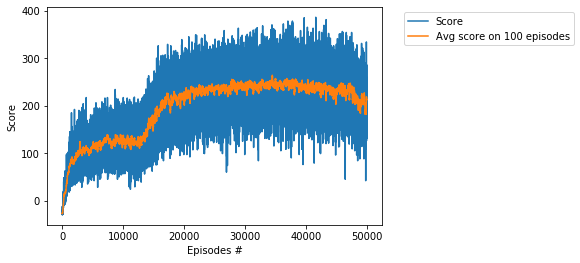

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg score on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

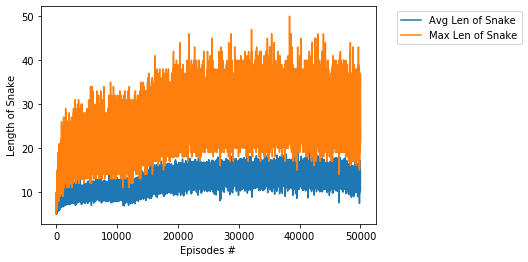

In [6]:
ax1 = fig.add_subplot(121)
plt.plot(np.arange(1, len(avg_len_of_snake)+1), avg_len_of_snake, label="Avg Len of Snake")
plt.plot(np.arange(1, len(max_len_of_snake)+1), max_len_of_snake, label="Max Len of Snake")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Length of Snake')
plt.xlabel('Episodes #')
plt.show()

mu:  24.93 , sigma:  5.23 , median:  25.0


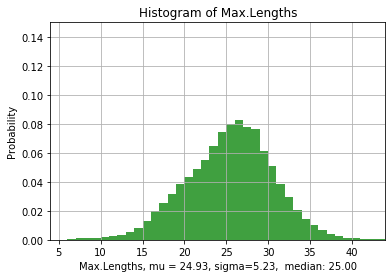

In [7]:
n, bins, patches = plt.hist(max_len_of_snake, 45, density=1, facecolor='green', alpha=0.75)
l = plt.plot(np.arange(1, len(bins) + 1), 'r--', linewidth=1)
mu = round(np.mean(max_len_of_snake), 2)
sigma = round(np.std(max_len_of_snake), 2)
median = round(np.median(max_len_of_snake), 2)
print('mu: ', mu, ', sigma: ', sigma, ', median: ', median)
plt.xlabel('Max.Lengths, mu = {:.2f}, sigma={:.2f},  median: {:.2f}'.format(mu, sigma, median))
plt.ylabel('Probability')
plt.title('Histogram of Max.Lengths')
plt.axis([4, 44, 0, 0.15])
plt.grid(True)

plt.show()